# 📝 Exercise M7.02

We presented different classification metrics in the previous notebook.
However, we did not use it with a cross-validation. This exercise aims at
practicing and implementing cross-validation.

We will reuse the blood transfusion dataset.

In [1]:
import pandas as pd

blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

First, create a decision tree classifier.

In [2]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()

Create a `StratifiedKFold` cross-validation object. Then use it inside the
`cross_val_score` function to evaluate the decision tree. We will first use
the accuracy as a score function. Explicitly use the `scoring` parameter
of `cross_val_score` to compute the accuracy (even if this is the default
score). Check its documentation to learn how to do that.

In [21]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

strat_fold = StratifiedKFold(n_splits=10)
cv_decision_t = cross_val_score(model_tree, data, target, cv=strat_fold, scoring='accuracy', n_jobs=2)
f"{cv_decision_t.mean():.3f} +/- {cv_decision_t.std():.3f}"

'0.637 +/- 0.141'

Repeat the experiment by computing the `balanced_accuracy`.

In [22]:
cv_decision_t2 = cross_val_score(model_tree, data, target, cv=strat_fold, scoring='balanced_accuracy', n_jobs=2)
f"{cv_decision_t2.mean():.3f} +/- {cv_decision_t2.std():.3f}"

'0.505 +/- 0.107'

We will now add a bit of complexity. We would like to compute the precision
of our model. However, during the course we saw that we need to mention the
positive label which in our case we consider to be the class `donated`.

We will show that computing the precision without providing the positive
label will not be supported by scikit-learn because it is indeed ambiguous.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
try:
    scores = cross_val_score(tree, data, target, cv=10, scoring="precision")
except ValueError as exc:
    print(exc)

/Users/nirvanabear/.local/share/virtualenvs/scikit-learn-mooc-btn2WeXi/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nirvanabear/.local/share/virtualenvs/scikit-learn-mooc-btn2WeXi/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/nirvanabear/.local/share/virtualenvs/scikit-learn-mooc-btn2WeXi/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/nirvanabear/.local/share/virtualenvs/scikit-learn-mooc-btn2WeXi/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/nirvanabear/.local/

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last">We catch the exception with a <tt class="docutils literal">try</tt>/<tt class="docutils literal">except</tt> pattern to be able to print it.</p>
</div>
We get an exception because the default scorer has its positive label set to
one (`pos_label=1`), which is not our case (our positive label is "donated").
In this case, we need to create a scorer using the scoring function and the
helper function `make_scorer`.

So, import `sklearn.metrics.make_scorer` and
`sklearn.metrics.precision_score`. Check their documentations for more
information.
Finally, create a scorer by calling `make_scorer` using the score function
`precision_score` and pass the extra parameter `pos_label="donated"`.

In [10]:
from sklearn.metrics import make_scorer, precision_score

scorer_donated = make_scorer(precision_score, pos_label='donated')

Now, instead of providing the string `"precision"` to the `scoring` parameter
in the `cross_val_score` call, pass the scorer that you created above.

In [23]:
cv_decision_t3 = cross_val_score(model_tree, data, target, cv=strat_fold, scoring=scorer_donated, n_jobs=2)
f"{cv_decision_t3.mean():.3f} +/- {cv_decision_t3.std():.3f}"

'0.249 +/- 0.167'

`cross_val_score` will only compute a single score provided to the `scoring`
parameter. The function `cross_validate` allows the computation of multiple
scores by passing a list of string or scorer to the parameter `scoring`,
which could be handy.

Import `sklearn.model_selection.cross_validate` and compute the accuracy and
balanced accuracy through cross-validation. Plot the cross-validation score
for both metrics using a box plot.

In [24]:
from sklearn.model_selection import cross_validate

cv_dt_accuracies = cross_validate(model_tree, data, target, cv=strat_fold, scoring=['accuracy', 'balanced_accuracy'], n_jobs=2)
cv_dt_accuracies

{'fit_time': array([0.00497222, 0.00781894, 0.00423598, 0.00475121, 0.00699902,
        0.00461102, 0.00649405, 0.00407815, 0.00591898, 0.0063839 ]),
 'score_time': array([0.0039928 , 0.00258899, 0.00334525, 0.00419688, 0.00331712,
        0.00303793, 0.00351477, 0.00382686, 0.00561309, 0.00623202]),
 'test_accuracy': array([0.29333333, 0.50666667, 0.78666667, 0.56      , 0.57333333,
        0.64      , 0.69333333, 0.78666667, 0.66216216, 0.74324324]),
 'test_balanced_accuracy': array([0.42105263, 0.46637427, 0.66959064, 0.40643275, 0.41520468,
        0.42105263, 0.55116959, 0.74561404, 0.49174407, 0.50309598])}

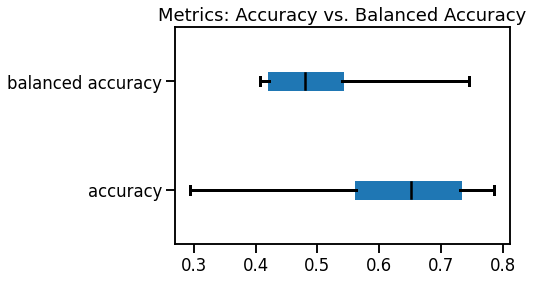

In [25]:
import matplotlib.pyplot as plt

accuracies = pd.DataFrame({'accuracy': cv_dt_accuracies['test_accuracy'], 'balanced accuracy': cv_dt_accuracies['test_balanced_accuracy']})
color = {"whiskers": "black", "medians": "black", "caps": "black"}
accuracies.plot.box(color=color, vert=False)
_ = plt.title("Metrics: Accuracy vs. Balanced Accuracy")

In [26]:
10 / (10+7)

0.5882352941176471

In [28]:
9 / (9+3)

0.75

In [29]:
10/(10+1)

0.9090909090909091

In [30]:
9/(9+2)

0.8181818181818182